In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import json
import pandas as pd
import time

# Problem definition

In [ ]:
NUMBERS = [2, 3, 5, 7, 10, 12, 15, 20, 23, 25, 30, 35, 40, 50, 60]
OPERATIONS = ["+", "-", "*", "/"]
TARGET = 567

def f(operation):
  value = abs(operation.evaluate() - TARGET)
  # Some unvalid expressions can lead to nan (when inf * 0 happens). Give them f = inf.
  if np.isnan(value): value = float('inf')

  # Apply a penalization if the operation has less than 8 numbers
  pen_term = 8 - len(operation.numbers)
  if pen_term > 0:
    value += 50 * pen_term

  return value

def check_valid(operation):
  return len(operation.numbers) >= 8

def f2(operation):
  value = abs(operation.evaluate() - TARGET)
  # Some unvalid expressions can lead to nan (when inf * 0 happens). Give them f = inf.
  if np.isnan(value): value = float('inf')

  # Apply a penalization if the operation has less than 8 numbers
  pen_term = 8 - len(operation.numbers)
  if pen_term > 0:
    value += 50 * pen_term

  # Apply a second penalization if the operation repeats numbers
  pen_term2 = (np.unique(operation.numbers, return_counts=True)[1] - 1).sum().item() # Number of repetitions
  value += 100 * pen_term2
  return value

def check_valid2(operation):
  return len(operation.numbers) >= 8 and np.all(np.unique(operation.numbers, return_counts=True)[1] == 1)

# Solution space

In [ ]:
class Operation:
    def __init__(self, numbers, operations, order):
        self.numbers = numbers
        self.operations = operations
        self.order = order

    def __str__(self):
        return f"{self.numbers} {self.operations} {self.order}"

    def __repr__(self):
        return self.__str__()

    def evaluate(self):
      # Copy the numbers list to avoid modifying the original
      num_list = self.numbers[:]
      op_list = self.operations[:]
      order_list = self.order[:]

      for i in range(len(order_list)):

          op_index = order_list[i]

          num1 = num_list[op_index]
          num2 = num_list[op_index + 1]
          operation = op_list[op_index]

          if operation == '+':
              result = num1 + num2
          elif operation == '-':
              result = num1 - num2
          elif operation == '*':
              result = num1 * num2
          elif operation == '/':
              result = num1 / num2 if num2 != 0 else float('inf')

          # Replace the numbers in the list with the result of the operation
          num_list[op_index] = result
          num_list.pop(op_index + 1)  # Remove the second number

          # Remove the operation from the list
          op_list.pop(op_index)

          # Decrement all indices that are greater than op_index
          order_list = [i - 1 if i > op_index else i for i in order_list]

      # The result of the final evaluation is the only element left in num_list
      return num_list[0]

    def copy(self):
        return Operation(self.numbers.copy(), self.operations.copy(), self.order.copy())


In [ ]:
example = Operation([4, 5, 6, 7], ['+', '-', '/'], [2,0,1])
print(example)
print(example.evaluate())

[4, 5, 6, 7] ['+', '-', '/'] [2, 0, 1]
8.142857142857142


In [ ]:
ejemplo = Operation([35, 30, 25, 12, 20, 50, 3, 2, 7, 10, 23, 5], ['+', '*', '*', '/', '+', '+', '-', '+', '+', '+', '+'], [1, 3, 0, 6, 2, 8, 4, 5, 9, 7, 10])
print(ejemplo)
print(ejemplo.evaluate())

[35, 30, 25, 12, 20, 50, 3, 2, 7, 10, 23, 5] ['+', '*', '*', '/', '+', '+', '-', '+', '+', '+', '+'] [1, 3, 0, 6, 2, 8, 4, 5, 9, 7, 10]
567.0


# Mutations

Next, we define some functions that generate neighbouring solutions to the one provided, by seven different mechanisms.

In [ ]:
from re import L
import random
def swap_random(l):
    i = random.randint(0, len(l) - 1)
    j = random.randint(0, len(l) - 1)
    l[i], l[j] = l[j], l[i]
    return l

# Create a new operation that has a different order of operations
def swap_order(operation):
    new_op = operation.copy()
    new_op.order = swap_random(new_op.order)
    return new_op

def swap_numbers(operation):
    new_op = operation.copy()
    new_op.numbers = swap_random(new_op.numbers)
    return new_op

def swap_operations(operation):
    new_op = operation.copy()
    new_op.operations = swap_random(new_op.operations)
    return new_op

def change_operation(operation):
    new_op = operation.copy()
    new_op.operations[random.randint(0, len(new_op.operations) - 1)] = random.choice(OPERATIONS)
    return new_op

def change_number(operation):
    new_op = operation.copy()
    new_op.numbers[random.randint(0, len(new_op.numbers) - 1)] = random.choice(NUMBERS)
    return new_op

# We will only add and remove operations from the end of the list, since later they can swap.
# Maybe we can try later if allowing inserts and pops in random places improves.
def add_operation(operation):
    new_op = operation.copy()
    new_op.operations.append(random.choice(OPERATIONS)) # Add a new operation at the end
    new_op.order.append(len(new_op.operations) - 1) # Make that operation the lowest priority
    new_op.numbers.append(random.choice(NUMBERS)) # Add a new number at the end to operate with
    return new_op

def remove_operation(operation):
    new_op = operation.copy()
    new_op.order.remove(len(new_op.operations) - 1) # Remove the last operation from the order list
    new_op.operations = new_op.operations[:-1] # Remove the last operation
    new_op.numbers = new_op.numbers[:-1] # Remove the last number
    return new_op

Some of the previous functions (`change_number` and `add_operation`) may generate solutions with repeated numbers. Since we also want to solve a version of the problem with no repeated numbers as a hard restriction (i.e. no intermediate solutions with repeated numbers allowed), we will program counterparts that prevent repeated numbers:

In [ ]:
def change_number_nrpt(operation):
    if len(operation.numbers) >= len(NUMBERS):
        return operation
    new_op = operation.copy()
    try:
      new_op.numbers[random.randint(0, len(new_op.numbers) - 1)] = random.choice(list(set(NUMBERS)-set(new_op.numbers)))
    except:
      print(operation)
      raise
    return new_op

def add_operation_nrpt(operation):
    if len(operation.numbers) >= len(NUMBERS):
        return operation
    new_op = operation.copy()
    new_op.operations.append(random.choice(OPERATIONS)) # Add a new operation at the end
    new_op.order.append(len(new_op.operations) - 1) # Make that operation the lowest priority
    new_op.numbers.append(random.choice(list(set(NUMBERS)-set(new_op.numbers)))) # Add a new number at the end to operate with
    return new_op

We aggregate these functions into two neighbour generator functions, that run one of the above at random with uniform probability:

In [ ]:
# Generate a random neighbour solution
def get_neighbour(operation):
  calls = [swap_order, swap_numbers, swap_operations, change_operation, change_number, add_operation, remove_operation]
  if len(operation.operations) == 0:
    calls = [add_operation] # If the operation is just a number, prevent from doing any changes that require operations.
  return random.choice(calls)(operation)

# Generate a random neighbour solution without adding repeated numbers.
def get_neighbour_nrpt(operation):
  calls = [swap_order, swap_numbers, swap_operations, change_operation, change_number_nrpt, add_operation_nrpt, remove_operation]
  if len(operation.operations) == 0:
    calls = [add_operation_nrpt] # If the operation is just a number, prevent from doing any changes that require operations.
  return random.choice(calls)(operation)

# Simulated annealing

In [ ]:
import math

"""
Runs the simulated annealing metaheuristic.
Args:
  - x0: initial solution.
  - f: function to be minimized.
  - check_valid: solution -> bool function. Checks that the solution satisfies all restrictions of the problem.
  - gen_neihbour: function that defines the solution environment. Generates a neighbour solution from another solution.
  - T0, alpha: parameters.
  - max_iterations, tol: stop criteria.
"""
def simulated_annealing(x0, f, check_valid, gen_neighbour, T0=1000, alpha=0.99, max_iterations=1000, tol=0.01, log=True):
  # Log info
  X = [x0]
  V = [x0.evaluate()]
  F = [f(x0)]
  Tv = [T0]

  # Run SA
  x = x0
  T = T0
  best_x, best_f = x, f(x)

  stop_counter = 0
  for i in range(max_iterations):
    x_new = gen_neighbour(x)
    f_new = f(x_new)
    delta_f = f_new - f(x)

    stop_counter += 1
    if delta_f < 0:
      x = x_new
      if f_new < best_f and check_valid(x_new):
        best_x, best_f = x, f_new
        stop_counter = 0
    else:
      u = random.random()
      if u < math.exp(-delta_f / T):
        x = x_new
        if f_new < best_f and check_valid(x_new):
          best_x, best_f = x, f_new
          stop_counter = 0

    T = T * alpha

    # Print Current info
    if log:
      print(f"Iter: {i} | f: {f(x):.3f} | best_f: {best_f:.3f}")

    # Log
    X.append(x)
    V.append(x.evaluate())
    F.append(f(x))
    Tv.append(T)

    # Stop criteria
    if best_f < tol:
        if log:
          print(f"Solución encontrada")
        break

  return best_x, best_f, X, V, F, Tv

# Genetic algorithm

Define some specific functions for the genetic algorithm:

In [ ]:
def generate_population(size) -> list[Operation]:
    population = []
    for _ in range(size):
        n_initial = random.randint(8, len(NUMBERS)) # Number of numbers in the initial solution
        initial_op = Operation(
            numbers = random.sample(NUMBERS, k=n_initial),
            operations = random.choices(OPERATIONS, k=n_initial-1),
            order = random.sample(list(range(n_initial-1)), k=n_initial-1)
        )
        population.append(initial_op)
    return population

# Creates a new operation that is the sum of the first half of op1 and the second half of op2
def crossover(op1, op2):
    new_numbers = op1.numbers[:math.ceil(len(op1.numbers)/2)] + op2.numbers[len(op2.numbers)//2:]
    op1cut = len(op1.operations)//2
    op2cut = math.ceil(len(op2.operations)/2)
    new_operations = op1.operations[:op1cut] + ['+'] + op2.operations[op2cut:]
    new_order = [i for i in op1.order if i < op1cut] + [i - op2cut + op1cut + 1 for i in op2.order if i >= op2cut] + [op1cut]
    return Operation(new_numbers, new_operations, new_order)

# Crossover that avoids generating solutions with repeated numbers.
# 1. Creates a new solution as the sum of the halfs of op1 and op2
# 2. Shrinks the operation and replaces numbers as necessary to avoid repeated numbers.
def crossover_nrpt(op1, op2):
    new_numbers = op1.numbers[:math.ceil(len(op1.numbers)/2)] + op2.numbers[len(op2.numbers)//2:]
    op1cut = len(op1.operations)//2
    op2cut = math.ceil(len(op2.operations)/2)
    new_operations = op1.operations[:op1cut] + ['+'] + op2.operations[op2cut:]
    new_order = [i for i in op1.order if i < op1cut] + [i - op2cut + op1cut + 1 for i in op2.order if i >= op2cut] + [op1cut]

    # Ensure no number repetitions
    # If the operation is larger than NUMBERS, shrink it down so that no numbers have to be repeated.
    extra = len(new_numbers) - len(NUMBERS)
    if extra > 0:
        new_numbers = new_numbers[:len(new_numbers)-extra]
        new_operations = new_operations[:len(new_operations)-extra]
        new_order = [i for i in new_order if i < len(new_operations)]

    # Replace any repeated numbers with a number not in the operation.
    new_numbers = np.array(new_numbers)
    unique, counts = np.unique(new_numbers, return_counts=True)

    # Find duplicates and unused numbers
    duplicates = unique[counts > 1]
    if len(duplicates) > 0:
        unused = np.setdiff1d(NUMBERS, unique, assume_unique=True)

        # Replace duplicates with unused numbers
        for dup in duplicates:
            indices = np.where(new_numbers == dup)[0][1:]  # All occurrences except the first
            new_numbers[indices] = unused[:len(indices)] # Replace from unused numbers
            unused = unused[len(indices):]  # Remove used replacements

    return Operation(new_numbers.tolist(), new_operations, new_order)


def roulette_wheel_selection(population, f):
    # Calculate fitness for each individual (inverse of the function trying to minimize)
    fitnesses = np.array([1/f(i) for i in population])
    total_fitness = sum(fitnesses)
    prob = fitnesses / total_fitness

    # Select an individual with probability proportional to their fitness.
    selected = np.random.choice(population, p=prob)
    return selected

"""
Runs the genetic algorithm.
Args:
    - f: function to be minimized.
    - check_valid: solution -> bool function. Checks that the solution satisfies all restrictions of the problem.
    - crossover: a function that creates a child solution from two parent solutions.
    - mutate: a function that takes a solution and returns a mutated version of it.
    - population_size, mutation_rate: parameters.
    - max_generations, tol: stop criteria.
"""

def genetic_algorithm(f, check_valid, crossover, mutate, population_size=100,  mutation_rate=0.01, max_generations=1000, tol=0.01, log=True):
    population = generate_population(population_size)
    fitnesses = [f(ind) for ind in population]
    best_global_ind = population[np.argmin(fitnesses)]
    best_global_fitness = fitnesses[np.argmin(fitnesses)]

    # Log info
    X = [best_global_ind]
    V = [best_global_ind.evaluate()]
    F = [best_global_fitness]

    stop_counter = 0
    for gen in range(max_generations):
        fitnesses = [f(ind) for ind in population]
        best_idx = np.argmin(fitnesses)
        best_ind = population[best_idx]
        best_fitness =  fitnesses[best_idx]

        stop_counter += 1
        if best_global_fitness > best_fitness and check_valid(best_ind):
            best_global_ind = best_ind
            best_global_fitness = best_fitness
            stop_counter = 0

        if log:
            print(f"Generación: {gen + 1} | Mejor fitness: {best_fitness:.2f} (Global: {best_global_fitness:.2f}) | Resultado: {best_ind.evaluate():.2f} (Global: {best_global_ind.evaluate():.2f})")

        # Log info
        X.append(best_global_ind)
        V.append(best_global_ind.evaluate())
        F.append(best_global_fitness)

        # Stop criteria
        if best_global_fitness < tol or stop_counter > 20:
            if log:
                print(f"Solución encontrada")
            break

        new_population = []

        while len(new_population) < population_size:
            parent1 = roulette_wheel_selection(population, f)
            parent2 = roulette_wheel_selection(population, f)

            child = crossover(parent1, parent2)
            #child = parent1.copy()
            if random.random() < mutation_rate:
                child = mutate(child)

            new_population.append(child)

        population = new_population
    return best_global_ind, best_global_fitness, X, V, F

# Random search

As a comparison with the metaheuristics, we implement a classic method: random search. The algorithm consists on sampling a random neighbouring point and moving to it if the function there has a lower value.

```pseudo
Initialize x at random.
Until stop criteria:
    Sample x', neighbour of x
    if f(x') < f(x):
        x = x'
Return x'
```

In [ ]:
"""
Runs random search.
Args:
  - x0: initial solution.
  - f: function to be minimized.
  - check_valid: solution -> bool function. Checks that the solution satisfies all restrictions of the problem.
  - gen_neihbour: function that defines the solution environment. Generates a neighbour solution from another solution.
  - max_iterations, tol: stop criteria.
"""

def random_search(x0, f, check_valid, gen_neighbour, max_iterations=1000, tol=0.01, log=True):
  # Log info
  X = [x0]
  V = [x0.evaluate()]
  F = [f(x0)]

  x = x0
  best_x, best_f = x, f(x)

  #stop_counter = 0

  for i in range(max_iterations):
    neighbour = gen_neighbour(x)
    neighbour_f = f(neighbour)

    #stop_counter += 1
    if neighbour_f < f(x):
      x = neighbour

      if neighbour_f < best_f and check_valid(neighbour):
          best_x, best_f = neighbour, neighbour_f
          #stop_counter = 0

    # Print Current info
    if log:
      print(f"Iter: {i} | f: {f(x):.3f} | best_f: {best_f:.3f}")

    # Log
    X.append(x)
    V.append(x.evaluate())
    F.append(f(x))

    # Stop criteria
    if best_f < tol:
        if log:
          print(f"Solución encontrada")
        break

  return best_x, best_f, X, V, F

# Testing the algorithms

In this section we run the algorithms to solve the problem in three different ways:

P1: Allowing repetition of numbers in the operations:
- Fitness function: `f`
- Check valid function: `check_valid`
- Neighbour/mutation function: `get_neighbour`
- Crossover function: `crossover`

P2: Adding non-repetition of numbers as a soft restriction (penalization in the fitness function).
- Fitness function: `f2`
- Check valid function: `check_valid2`
- Neighbour/mutation function: `get_neighbour`
- Crossover function: `crossover`

P3: Adding non-repetition of numbers as a hard restriction (intermediate non-valid solutions not allowed)
- Fitness function: `f`
- Check valid function: `check_valid2`
- Neighbour/mutation function: `get_neighbour_nrpt`
- Crossover function: `crossover_nrpt`

Generate an initial solution for simulated annealing and random search.

In [ ]:
n_initial = 8 # Number of numbers in the initial solution
initial_op = Operation(
    numbers = random.sample(NUMBERS, k=n_initial),
    operations = random.choices(OPERATIONS, k=n_initial-1),
    order = random.sample(list(range(n_initial-1)), k=n_initial-1)
)

max_iter = 1000
tol = 0.01

## P1

Simulated Annealing

In [ ]:
P1sa_x, P1sa_f, P1sa_X, P1sa_V, P1sa_F, P1sa_Tv = simulated_annealing(initial_op, f, check_valid, get_neighbour, T0=500, alpha=0.90, max_iterations=max_iter, tol=tol)

Iter: 0 | f: 554.671 | best_f: 554.671
Iter: 1 | f: 554.671 | best_f: 554.671
Iter: 2 | f: 546.070 | best_f: 546.070
Iter: 3 | f: 523.070 | best_f: 523.070
Iter: 4 | f: 543.476 | best_f: 523.070
Iter: 5 | f: 543.476 | best_f: 523.070
Iter: 6 | f: 543.213 | best_f: 523.070
Iter: 7 | f: 589.530 | best_f: 523.070
Iter: 8 | f: 566.530 | best_f: 523.070
Iter: 9 | f: 566.530 | best_f: 523.070
Iter: 10 | f: 623.250 | best_f: 523.070
Iter: 11 | f: 616.936 | best_f: 523.070
Iter: 12 | f: 616.893 | best_f: 523.070
Iter: 13 | f: 616.893 | best_f: 523.070
Iter: 14 | f: 611.750 | best_f: 523.070
Iter: 15 | f: 566.895 | best_f: 523.070
Iter: 16 | f: 566.895 | best_f: 523.070
Iter: 17 | f: 611.750 | best_f: 523.070
Iter: 18 | f: 611.750 | best_f: 523.070
Iter: 19 | f: 611.750 | best_f: 523.070
Iter: 20 | f: 556.750 | best_f: 523.070
Iter: 21 | f: 554.250 | best_f: 523.070
Iter: 22 | f: 469.143 | best_f: 469.143
Iter: 23 | f: 274.143 | best_f: 274.143
Iter: 24 | f: 274.143 | best_f: 274.143
Iter: 25 |

Genetic Algorithm

In [ ]:
P1ga_x, P1ga_f, P1ga_X, P1ga_V, P1ga_F = genetic_algorithm(f, check_valid, crossover, mutate=get_neighbour, population_size=100, max_generations=max_iter, mutation_rate=0.1, tol=tol)

Generación: 1 | Mejor fitness: 137.87 (Global: 137.87) | Resultado: 429.13 (Global: 429.13)
Generación: 2 | Mejor fitness: 16.50 (Global: 16.50) | Resultado: 550.50 (Global: 550.50)
Generación: 3 | Mejor fitness: 8.50 (Global: 8.50) | Resultado: 575.50 (Global: 575.50)
Generación: 4 | Mejor fitness: 8.50 (Global: 8.50) | Resultado: 575.50 (Global: 575.50)
Generación: 5 | Mejor fitness: 5.08 (Global: 5.08) | Resultado: 572.08 (Global: 572.08)
Generación: 6 | Mejor fitness: 5.08 (Global: 5.08) | Resultado: 572.08 (Global: 572.08)
Generación: 7 | Mejor fitness: 6.43 (Global: 5.08) | Resultado: 560.57 (Global: 572.08)
Generación: 8 | Mejor fitness: 5.58 (Global: 5.08) | Resultado: 572.58 (Global: 572.08)
Generación: 9 | Mejor fitness: 5.50 (Global: 5.08) | Resultado: 572.50 (Global: 572.08)
Generación: 10 | Mejor fitness: 2.25 (Global: 2.25) | Resultado: 569.25 (Global: 569.25)
Generación: 11 | Mejor fitness: 1.17 (Global: 1.17) | Resultado: 565.83 (Global: 565.83)
Generación: 12 | Mejor f

Random Search

In [ ]:
P1rs_x, P1rs_f, P1rs_X, P1rs_V, P1rs_F = random_search(initial_op, f, check_valid, get_neighbour, max_iterations=max_iter, tol=tol)

Iter: 0 | f: 554.671 | best_f: 554.671
Iter: 1 | f: 554.671 | best_f: 554.671
Iter: 2 | f: 514.059 | best_f: 514.059
Iter: 3 | f: 514.059 | best_f: 514.059
Iter: 4 | f: 514.059 | best_f: 514.059
Iter: 5 | f: 514.059 | best_f: 514.059
Iter: 6 | f: 514.059 | best_f: 514.059
Iter: 7 | f: 514.059 | best_f: 514.059
Iter: 8 | f: 475.163 | best_f: 475.163
Iter: 9 | f: 432.625 | best_f: 432.625
Iter: 10 | f: 432.625 | best_f: 432.625
Iter: 11 | f: 432.625 | best_f: 432.625
Iter: 12 | f: 432.625 | best_f: 432.625
Iter: 13 | f: 432.625 | best_f: 432.625
Iter: 14 | f: 432.625 | best_f: 432.625
Iter: 15 | f: 408.719 | best_f: 408.719
Iter: 16 | f: 408.719 | best_f: 408.719
Iter: 17 | f: 202.953 | best_f: 202.953
Iter: 18 | f: 202.953 | best_f: 202.953
Iter: 19 | f: 202.953 | best_f: 202.953
Iter: 20 | f: 202.953 | best_f: 202.953
Iter: 21 | f: 202.953 | best_f: 202.953
Iter: 22 | f: 202.953 | best_f: 202.953
Iter: 23 | f: 202.953 | best_f: 202.953
Iter: 24 | f: 202.953 | best_f: 202.953
Iter: 25 |

Show results:

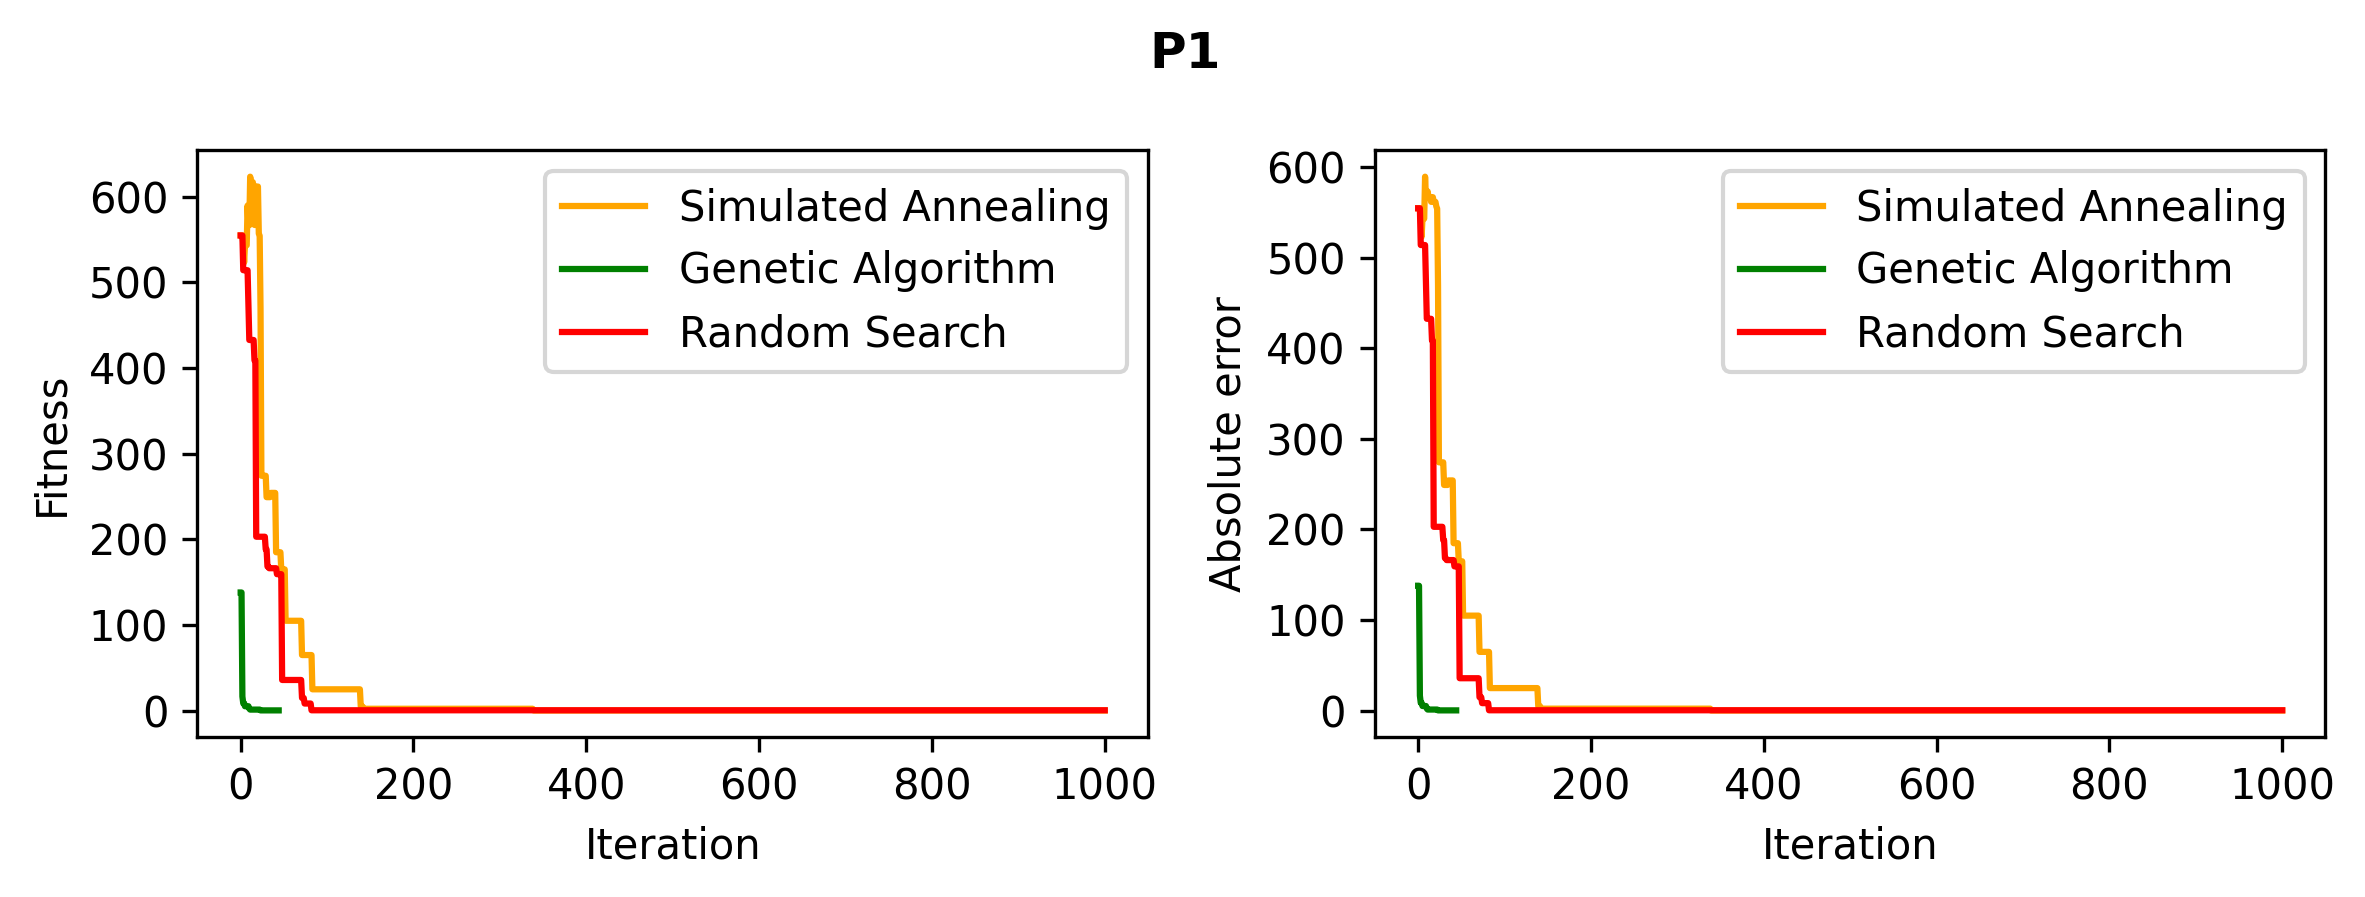

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
ax[0].plot(P1sa_F, color='orange', label='Simulated Annealing')
ax[0].plot(P1ga_F, color='green', label='Genetic Algorithm')
ax[0].plot(P1rs_F, color='red', label='Random Search')

ax[0].set_ylabel('Fitness')
ax[0].set_xlabel('Iteration')

ax[1].plot(np.abs(np.array(P1sa_V) - TARGET), color='orange', label='Simulated Annealing')
ax[1].plot(np.abs(np.array(P1ga_V) - TARGET), color='green', label='Genetic Algorithm')
ax[1].plot(np.abs(np.array(P1rs_V) - TARGET), color='red', label='Random Search')

ax[1].set_ylabel('Absolute error')
ax[1].set_xlabel('Iteration')

for a in ax:
    a.legend()

plt.suptitle("P1", fontweight='bold')
plt.tight_layout()
plt.show()

## P2

In [ ]:
P2sa_x, P2sa_f, P2sa_X, P2sa_V, P2sa_F, P2sa_Tv = simulated_annealing(initial_op, f2, check_valid2, get_neighbour, T0=1000, alpha=0.90, max_iterations=max_iter, tol=tol, log=False)
P2ga_x, P2ga_f, P2ga_X, P2ga_V, P2ga_F = genetic_algorithm(f2, check_valid2, crossover, mutate=get_neighbour, population_size=100, max_generations=max_iter, mutation_rate=0.1, tol=tol, log=False)
P2rs_x, P2rs_f, P2rs_X, P2rs_V, P2rs_F = random_search(initial_op, f2, check_valid2, get_neighbour, max_iterations=max_iter, tol=tol, log=False)

Show results:

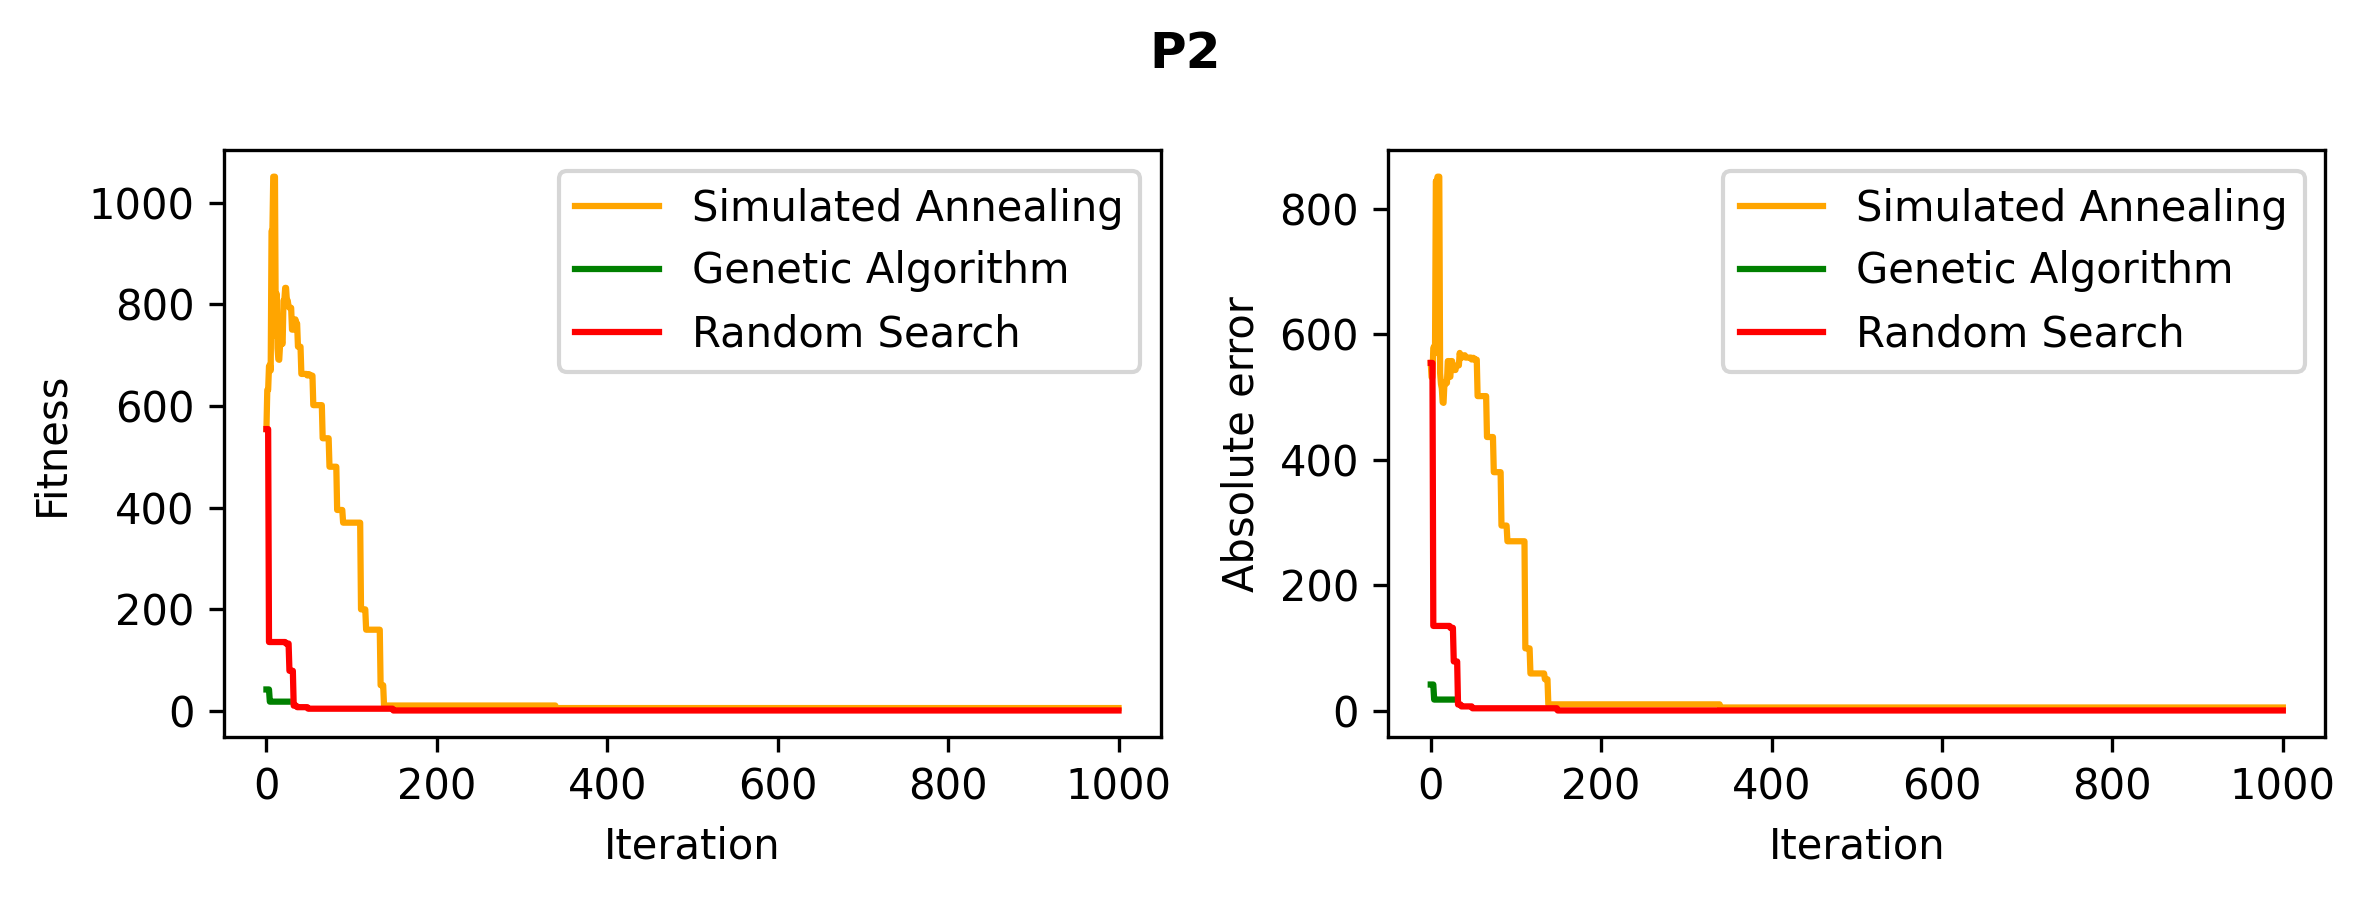

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
ax[0].plot(P2sa_F, color='orange', label='Simulated Annealing')
ax[0].plot(P2ga_F, color='green', label='Genetic Algorithm')
ax[0].plot(P2rs_F, color='red', label='Random Search')

ax[0].set_ylabel('Fitness')
ax[0].set_xlabel('Iteration')

ax[1].plot(np.abs(np.array(P2sa_V) - TARGET), color='orange', label='Simulated Annealing')
ax[1].plot(np.abs(np.array(P2ga_V) - TARGET), color='green', label='Genetic Algorithm')
ax[1].plot(np.abs(np.array(P2rs_V) - TARGET), color='red', label='Random Search')

ax[1].set_ylabel('Absolute error')
ax[1].set_xlabel('Iteration')

for a in ax:
    a.legend()

plt.suptitle('P2', fontweight='bold')
plt.tight_layout()
plt.show()

# P3

In [ ]:
P3sa_x, P3sa_f, P3sa_X, P3sa_V, P3sa_F, P3sa_Tv = simulated_annealing(initial_op, f, check_valid2, get_neighbour_nrpt, T0=500, alpha=0.90, max_iterations=max_iter, tol=tol, log=False)
P3ga_x, P3ga_f, P3ga_X, P3ga_V, P3ga_F = genetic_algorithm(f, check_valid2, crossover_nrpt, mutate=get_neighbour_nrpt, population_size=100, max_generations=max_iter, mutation_rate=0.1, tol=tol, log=False)
P3rs_x, P3rs_f, P3rs_X, P3rs_V, P3rs_F = random_search(initial_op, f, check_valid2, get_neighbour_nrpt, max_iterations=1000, tol=0.01, log=False)

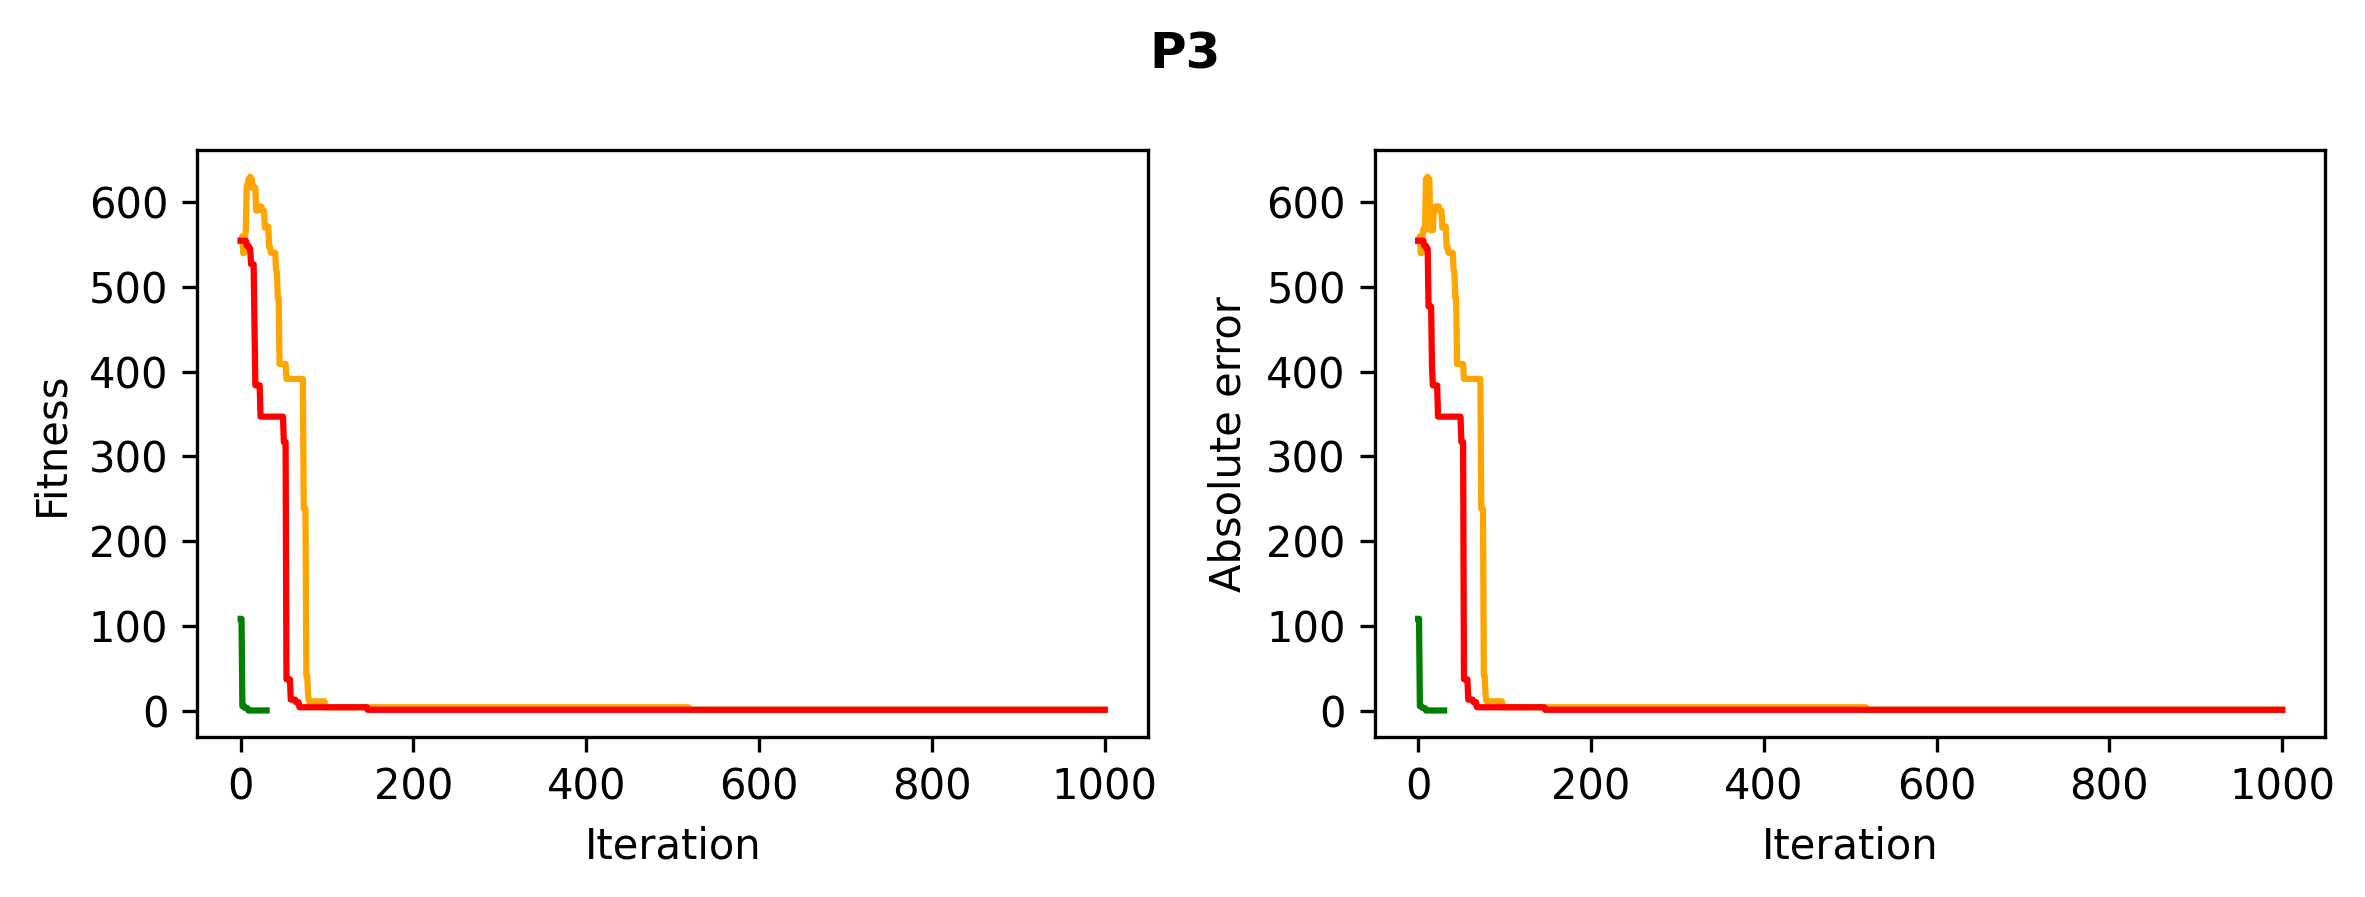

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
ax[0].plot(P3sa_F, color='orange', label='Simulated Annealing')
ax[0].plot(P3ga_F, color='green', label='Genetic Algorithm')
ax[0].plot(P3rs_F, color='red', label='Random Search')

ax[0].set_ylabel('Fitness')
ax[0].set_xlabel('Iteration')

ax[1].plot(np.abs(np.array(P3sa_V) - TARGET), color='orange', label='Simulated Annealing')
ax[1].plot(np.abs(np.array(P3ga_V) - TARGET), color='green', label='Genetic Algorithm')
ax[1].plot(np.abs(np.array(P3rs_V) - TARGET), color='red', label='Random Search')

ax[1].set_ylabel('Absolute error')
ax[1].set_xlabel('Iteration')

plt.suptitle('P3', fontweight='bold')
plt.tight_layout()
plt.show()

# Search for best parameters

## Best $T_0$ for Simulated Annealing

We will set a $T_0$ such that there is a probability of 0.9 of taking a worse solution at the start.

We calculate the mean $\Delta f$ by sampling several starts:

In [ ]:
def estimate_T0(f, gen_neighbour, p_worse=0.9, nsamples=1000):
    dfs = np.zeros(int(nsamples))
    mean_df = 0
    samples = 0
    while samples < nsamples:
        n_initial = random.randint(8, len(NUMBERS)) # Number of numbers in the initial solution
        initial_op = Operation(
            numbers = random.sample(NUMBERS, k=n_initial),
            operations = random.choices(OPERATIONS, k=n_initial-1),
            order = random.sample(list(range(n_initial-1)), k=n_initial-1)
        )

        y = gen_neighbour(initial_op)
        f_y = f(y)
        f_initial = f(initial_op)
        if f_y > f_initial:
            df = f_y - f_initial
            dfs[samples] = df
            samples += 1

    T0 = - np.median(dfs) / math.log(p_worse)

    return T0, dfs

Estimate $T_0$ for problem P1:

In [ ]:
T0, dfs = estimate_T0(f, get_neighbour, p_worse=0.9, nsamples=1e6)
T0, np.median(dfs)

(np.float64(474.3412490853144), np.float64(49.97683860140614))

We use the median instead of the mean in the estimation of T0, as our neighbour definition generates a few operations that evaluate to extremely high values, increasing the mean artificially. Thus, we are calculating $T_0$ such that:

$$
p = \exp\left(-\frac{\Delta f_{1/2}}{T_0}\right) = 0.9
$$

where $p$ is the probability of accepting the worse value which has a median difference in fitness compared to the initial solution ($\Delta f_{1/2}$).

With this estimation of the temperature, 50% of the times a worse value is generated at the start of the algorithm, it will have a probability greater than 0.9 of being accepted.



We can see the disproportionately large mean due to a few high values in the following cell:

In [ ]:
import pandas as pd
pd.Series(dfs[~np.isinf(dfs)]).describe()

count    9.980790e+05
mean     2.500055e+17
std      2.497652e+20
min      5.684342e-14
25%      3.836317e+00
50%      4.988964e+01
75%      1.284254e+03
max      2.495252e+23
dtype: float64

Initial temperature estimation for problem P2:

In [ ]:
T0, dfs = estimate_T0(f2, get_neighbour, p_worse=0.9, nsamples=1e6)
T0

np.float64(949.1239100868128)

Initial temperature estimation for problem P3:

In [ ]:
T0, dfs = estimate_T0(f, get_neighbour_nrpt, p_worse=0.9, nsamples=1e6)
T0

np.float64(474.56095984171264)

# Algorithm comparisons

In this section, we statistically compare the three algorithms.

Number of runs for each algorithm and whether to run the algorithms or load results:

In [ ]:
N_RUNS = 100
RUN = False

Some useful functions:

In [ ]:
# Generic function to execute a function and measure the time it takes
def measure_execution_time(func, *args, **kwargs):
    start_time = time.time()
    results = func(*args, **kwargs)
    end_time = time.time()
    execution_time = end_time - start_time
    return results, execution_time

# Run and retrieve results for each algorithm
def run_algorithms(f, check_valid, gen_neighbour, crossover, N=100, T0=500, max_iter=1000, tol=0.01):
    sa_results = []; ga_results = []; rs_results = []

    # Simulated Annealing
    for i in range(N):
        # Generate an initial solution for Simulated Annealing and RandomSearch
        n_initial = random.randint(8, len(NUMBERS))
        initial = Operation(
            numbers = random.sample(NUMBERS, k=n_initial),
            operations = random.choices(OPERATIONS, k=n_initial-1),
            order = random.sample(list(range(n_initial-1)), k=n_initial-1)
        )

        (sa_x, sa_f, sa_X, sa_V, sa_F, sa_Tv), sa_time = measure_execution_time(
            simulated_annealing, initial, f, check_valid, gen_neighbour, T0=T0, alpha=0.90, max_iterations=max_iter, tol=tol, log=False
        )
        sa_results.append({
            "Algoritmo": "RS",
            "Ejecución": i + 1,
            "Tiempo de ejecución (s)": sa_time,
            "Iteraciones": len(sa_F) - 1,
            "Mejor solución": sa_x,
            "Mejor fitness": sa_f,
            "Trayectoria": sa_F
        })

        # Genetic Algorithm
        (ga_x, ga_f, ga_X, ga_V, ga_F), ga_time = measure_execution_time(
            genetic_algorithm, f, check_valid, crossover, gen_neighbour, population_size=100, mutation_rate=0.1, max_generations=max_iter, tol=tol, log=False
        )
        ga_results.append({
            "Algoritmo": "AG",
            "Ejecución": i + 1,
            "Tiempo de ejecución (s)": ga_time,
            "Iteraciones": len(ga_F) - 1,
            "Mejor solución": ga_x,
            "Mejor fitness": ga_f,
            "Trayectoria": ga_F
        })

        # Random Search
        (rs_x, rs_f, rs_X, rs_V, rs_F), rs_time = measure_execution_time(
            random_search, initial, f, check_valid, gen_neighbour, max_iterations=max_iter, tol=tol, log=False
        )
        rs_results.append({
            "Algoritmo": "BA",
            "Ejecución": i + 1,
            "Tiempo de ejecución (s)": rs_time,
            "Iteraciones": len(rs_F) - 1,
            "Mejor solución": rs_x,
            "Mejor fitness": rs_f,
            "Trayectoria": rs_F
        })

    return pd.concat([pd.DataFrame(sa_results), pd.DataFrame(ga_results), pd.DataFrame(rs_results)]).reset_index(drop=True)

# Function to plot the trajectories of the three algorithms from the results provided by `run_algorithms`
def plot_trajectories(df, title="", xlim=(0, 200), ylim=(0, 1000)):
    maxlen = max(map(len, df['Trayectoria']))
    padded = pd.concat([df['Algoritmo'], df['Trayectoria'].apply(lambda lst: np.pad(lst, (0, maxlen - len(lst)), mode='edge'))], axis=1)

    means = padded.groupby('Algoritmo')['Trayectoria'].agg(lambda x: np.mean(x.to_list(), axis=0))
    sems = padded.groupby('Algoritmo')['Trayectoria'].agg(lambda x: np.std(x.to_list(), axis=0) / np.sqrt(x.shape[0]))

    plt.figure(figsize=(8, 4))
    algorithms = {'RS': 'Recocido simulado', 'AG': 'Algoritmo genético', 'BA': 'Búsqueda aleatoria'}
    colors = {'RS': 'red', 'AG': 'green', 'BA': 'blue'}
    for algo, name in algorithms.items():
        mean = means[algo]
        sem = sems[algo]
        x = np.arange(len(mean))

        # Plot the mean line
        plt.plot(x, mean, label=f'{name}', linewidth=2, color=colors[algo])

        # Plot the envelope (mean ± SEM)
        plt.fill_between(x, mean - sem, mean + sem, alpha=0.3, color=colors[algo])

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Iteraciones', fontsize=14)
    plt.ylabel('Fitness', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=14)
    plt.grid(alpha=0.3)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.tight_layout()
    plt.show()

# Function to make boxplots of the final solutions from the results provided by `run_algorithms`
def plot_performance(df, suptitle=""):
    columns = ['Mejor fitness', 'Tiempo de ejecución (s)', 'Iteraciones']
    title_size = 14
    label_size = 12

    fig = plt.figure(figsize=(10, 6), dpi=300)
    axes = df.boxplot(columns, by='Algoritmo', ax=fig, layout=(2, 3), sharey=False, return_type='axes', showmeans=True, fontsize=label_size, grid=False,
                        boxprops=dict(linewidth=1.5),
                        medianprops=dict(color='red', linewidth=2),
                        meanprops=dict(marker='o', markerfacecolor='green', markersize=3),
                        whiskerprops=dict(color='black', linewidth=1.5),
                        capprops=dict(color='black', linewidth=1.5))

    axes['Mejor fitness'].set_title('Diferencia respecto al objetivo', fontsize=title_size)
    axes['Mejor fitness'].set_ylabel('Diferencia absoluta', fontsize=label_size)
    axes['Tiempo de ejecución (s)'].set_title('Tiempo de ejecución', fontsize=title_size)
    axes['Tiempo de ejecución (s)'].set_ylabel('Tiempo (s)', fontsize=label_size)
    axes['Iteraciones'].set_title('Iteraciones', fontsize=title_size)
    axes['Iteraciones'].set_ylabel('Nº de iteraciones', fontsize=label_size)

    for ax in axes.values:
        ax.set_xlabel('Algoritmo', fontsize=label_size)

    plt.suptitle(suptitle, fontweight='bold', fontsize=title_size)
    plt.tight_layout()
    return fig, axes

# Function to save the results of `run_algorithms` to csv
def save_csv(df, filename):
    df2 = df.copy()
    df2['Trayectoria'] = df2['Trayectoria'].apply(json.dumps) # Ensure that lists are parseable
    df2.to_csv(filename, index=False)

def load_csv(filename):
    df = pd.read_csv(filename)
    df['Trayectoria'] = df['Trayectoria'].apply(json.loads) # Parse lists
    return df

# Problem P1

Results for problem P1 (`f`, `check_valid`, `get_neighbour`, `crossover`):

In [ ]:
if RUN:
    P1df = run_algorithms(f, check_valid, get_neighbour, crossover, N = N_RUNS, T0 = 500)
    save_csv(P1df, 'P1results.csv')
else:
    P1df = load_csv('P1results.csv')
    print("Loaded results. Number of runs: ", P1df[P1df['Algoritmo'] == 'RS'].shape[0])

Loaded results. Number of runs:  100


## Plot trajectories

Next, we plot the trajectories of each algorithm with envelopes indicating the standard error:

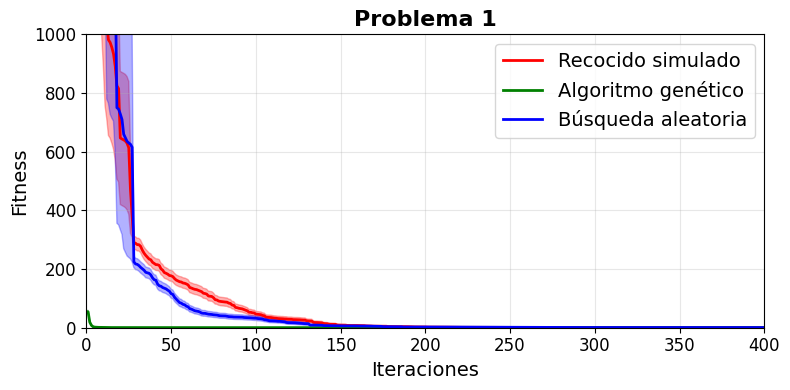

In [ ]:
plot_trajectories(P1df, "Problema 1", xlim=(0, 400), ylim=(0, 1000))

## Plot performance

Finally, we make a boxplot with the final solutions of each algorithm run:

<ipython-input-13-9a44b3d176eb>:107: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axes = df.boxplot(columns, by='Algoritmo', ax=fig, layout=(2, 3), sharey=False, return_type='axes', showmeans=True, fontsize=label_size, grid=False,


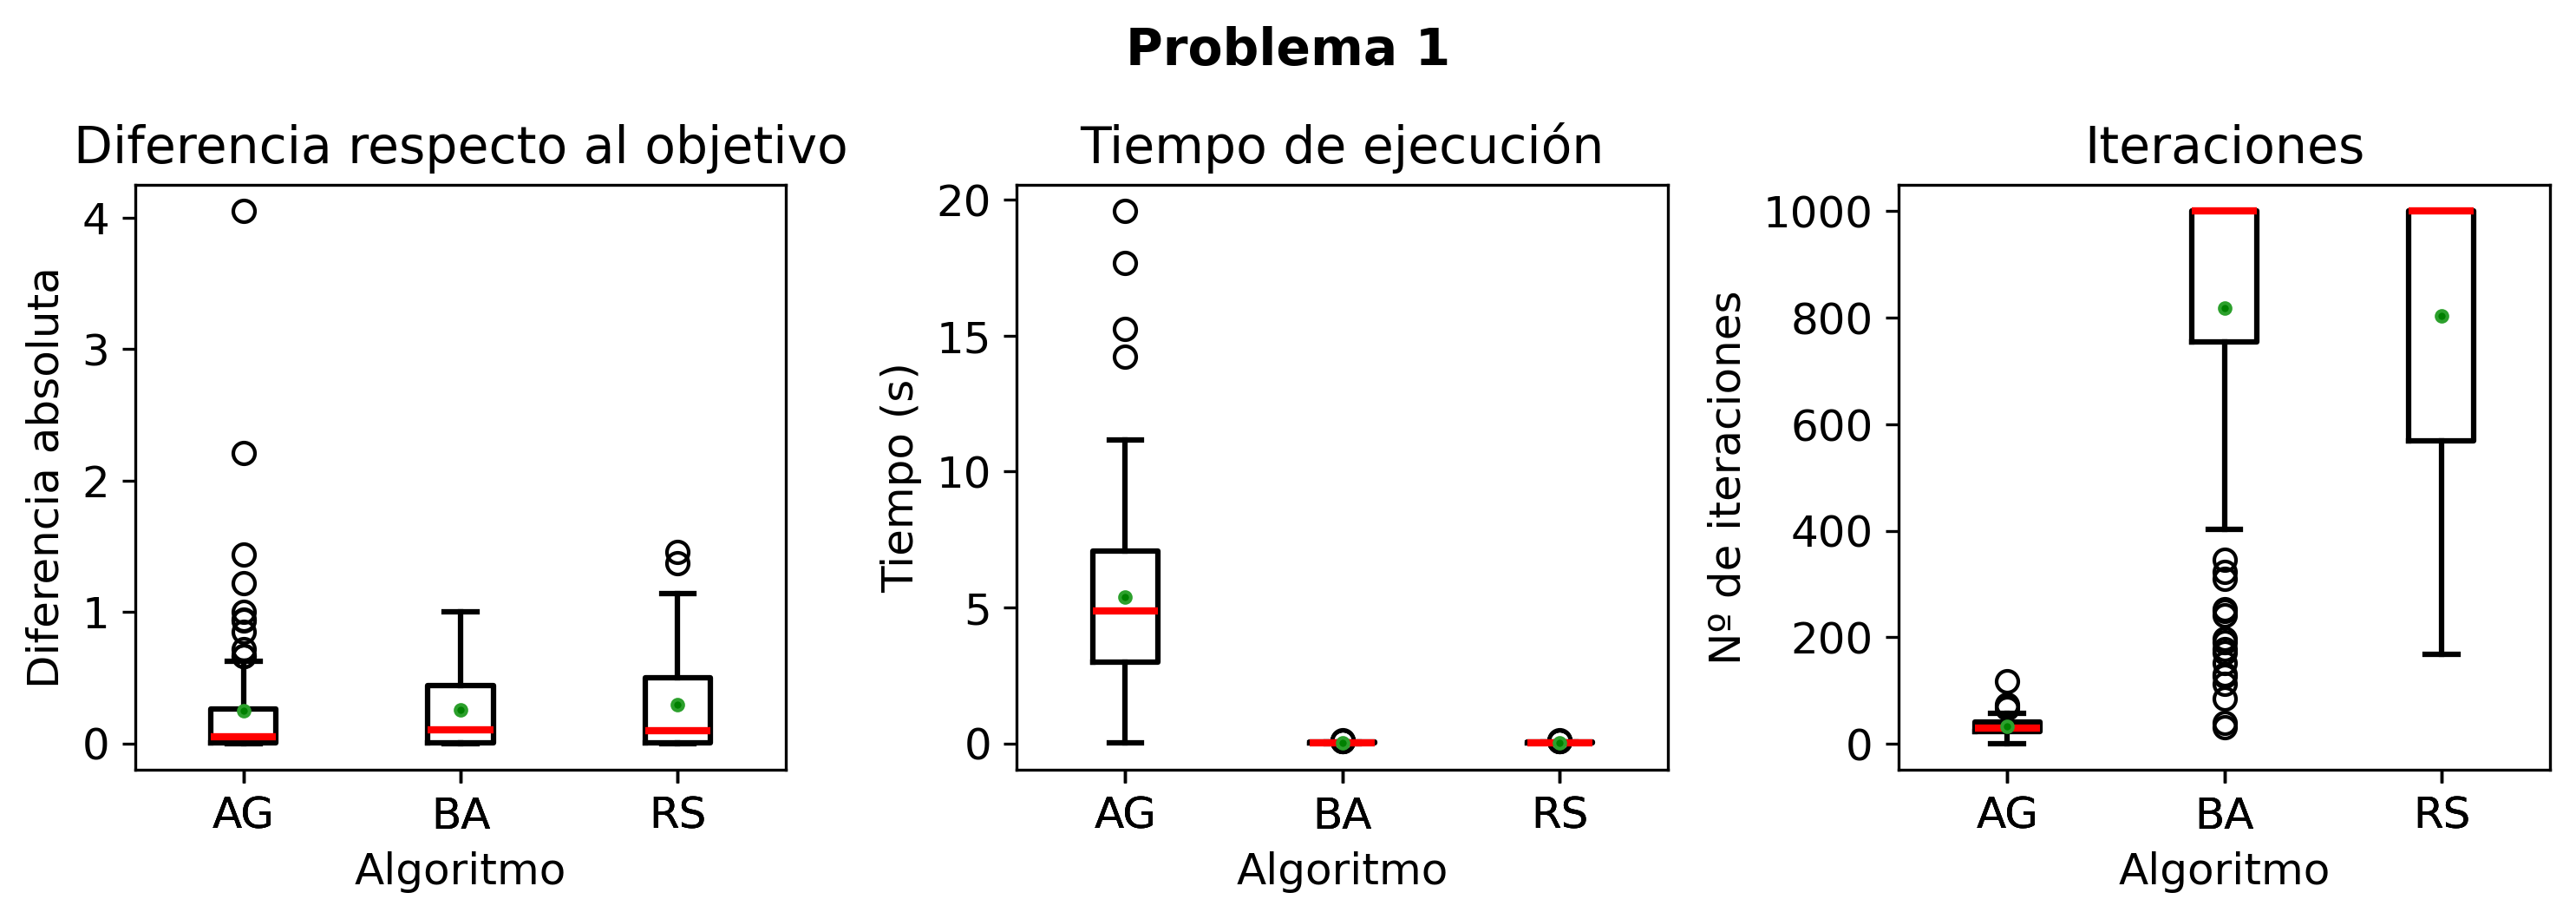

In [ ]:
plot_performance(P1df, "Problema 1")
plt.show()

Number of times each algorithm reached the global optimum (tol = 0.01):

In [ ]:
count_success = pd.concat([P1df.groupby('Algoritmo')['Mejor fitness'].agg(lambda x: np.sum(x < 0.01)),
           P1df.groupby('Algoritmo')['Mejor fitness'].agg(lambda x: np.sum(x < 0.01) / x.shape[0] * 100)], axis=1)
count_success.columns = ['Nº éxitos', '% éxitos']
count_success

,Nº éxitos,% éxitos
Algoritmo,,
AG,38,38.0
BA,29,29.0
RS,35,35.0


Best solutions found:

In [ ]:
best_solutions = P1df.loc[P1df.groupby("Algoritmo")["Mejor fitness"].idxmin(), ["Algoritmo", "Mejor solución", "Mejor fitness"]]
pd.set_option('display.max_colwidth', None)
best_solutions

,Algoritmo,Mejor solución,Mejor fitness
102,AG,"[40, 2, 23, 20, 25, 3, 23, 23, 50, 60, 40, 3, 20, 30] ['/', '+', '-', '-', '*', '+', '+', '-', '+', '-', '-', '-', '*'] [2, 4, 3, 0, 1, 5, 7, 12, 10, 11, 9, 8, 6]",0.0
205,BA,"[15, 40, 40, 10, 5, 7, 12, 60, 23, 15, 3, 50, 50] ['+', '/', '*', '+', '-', '*', '*', '-', '-', '*', '-', '-'] [3, 9, 5, 11, 1, 2, 4, 7, 8, 6, 10, 0]",0.0
7,RS,"[30, 40, 7, 20, 50, 2, 5, 12, 15, 30, 15, 5, 35, 60, 15, 10] ['*', '+', '+', '-', '*', '*', '/', '*', '-', '-', '-', '-', '-', '+', '-'] [6, 4, 7, 0, 3, 5, 2, 8, 1, 9, 10, 11, 12, 13, 14]",0.0


# Problem P2

Results for problem P2 (`f2`, `check_valid2`, `get_neighbour`, `crossover`):

In [ ]:
if RUN:
    P2df = run_algorithms(f2, check_valid2, get_neighbour, crossover, N = N_RUNS, T0 = 1000)
    save_csv(P2df, 'P2results.csv')
else:
    P2df = load_csv('P2results.csv')
    print("Loaded results. Number of runs: ", P2df[P2df['Algoritmo'] == 'RS'].shape[0])

Loaded results. Number of runs:  100


## Plot trajectories

Next, we plot the trajectories of each algorithm with envelopes indicating the standard error:

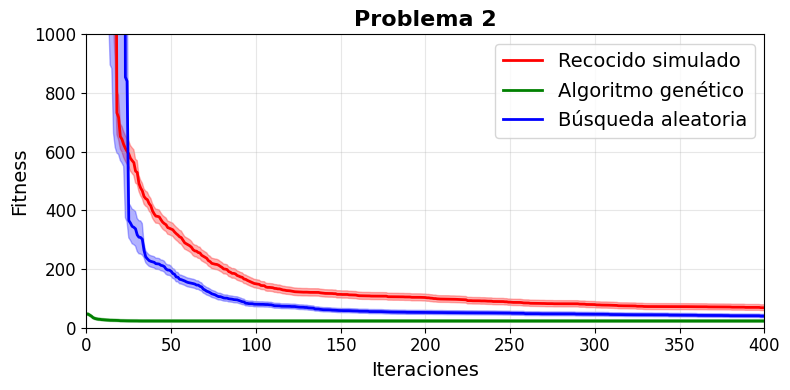

In [ ]:
plot_trajectories(P2df, "Problema 2", xlim=(0, 400), ylim=(0, 1000))

## Plot performance

Finally, we make a boxplot with the final solutions of each algorithm run:

<ipython-input-13-9a44b3d176eb>:107: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axes = df.boxplot(columns, by='Algoritmo', ax=fig, layout=(2, 3), sharey=False, return_type='axes', showmeans=True, fontsize=label_size, grid=False,


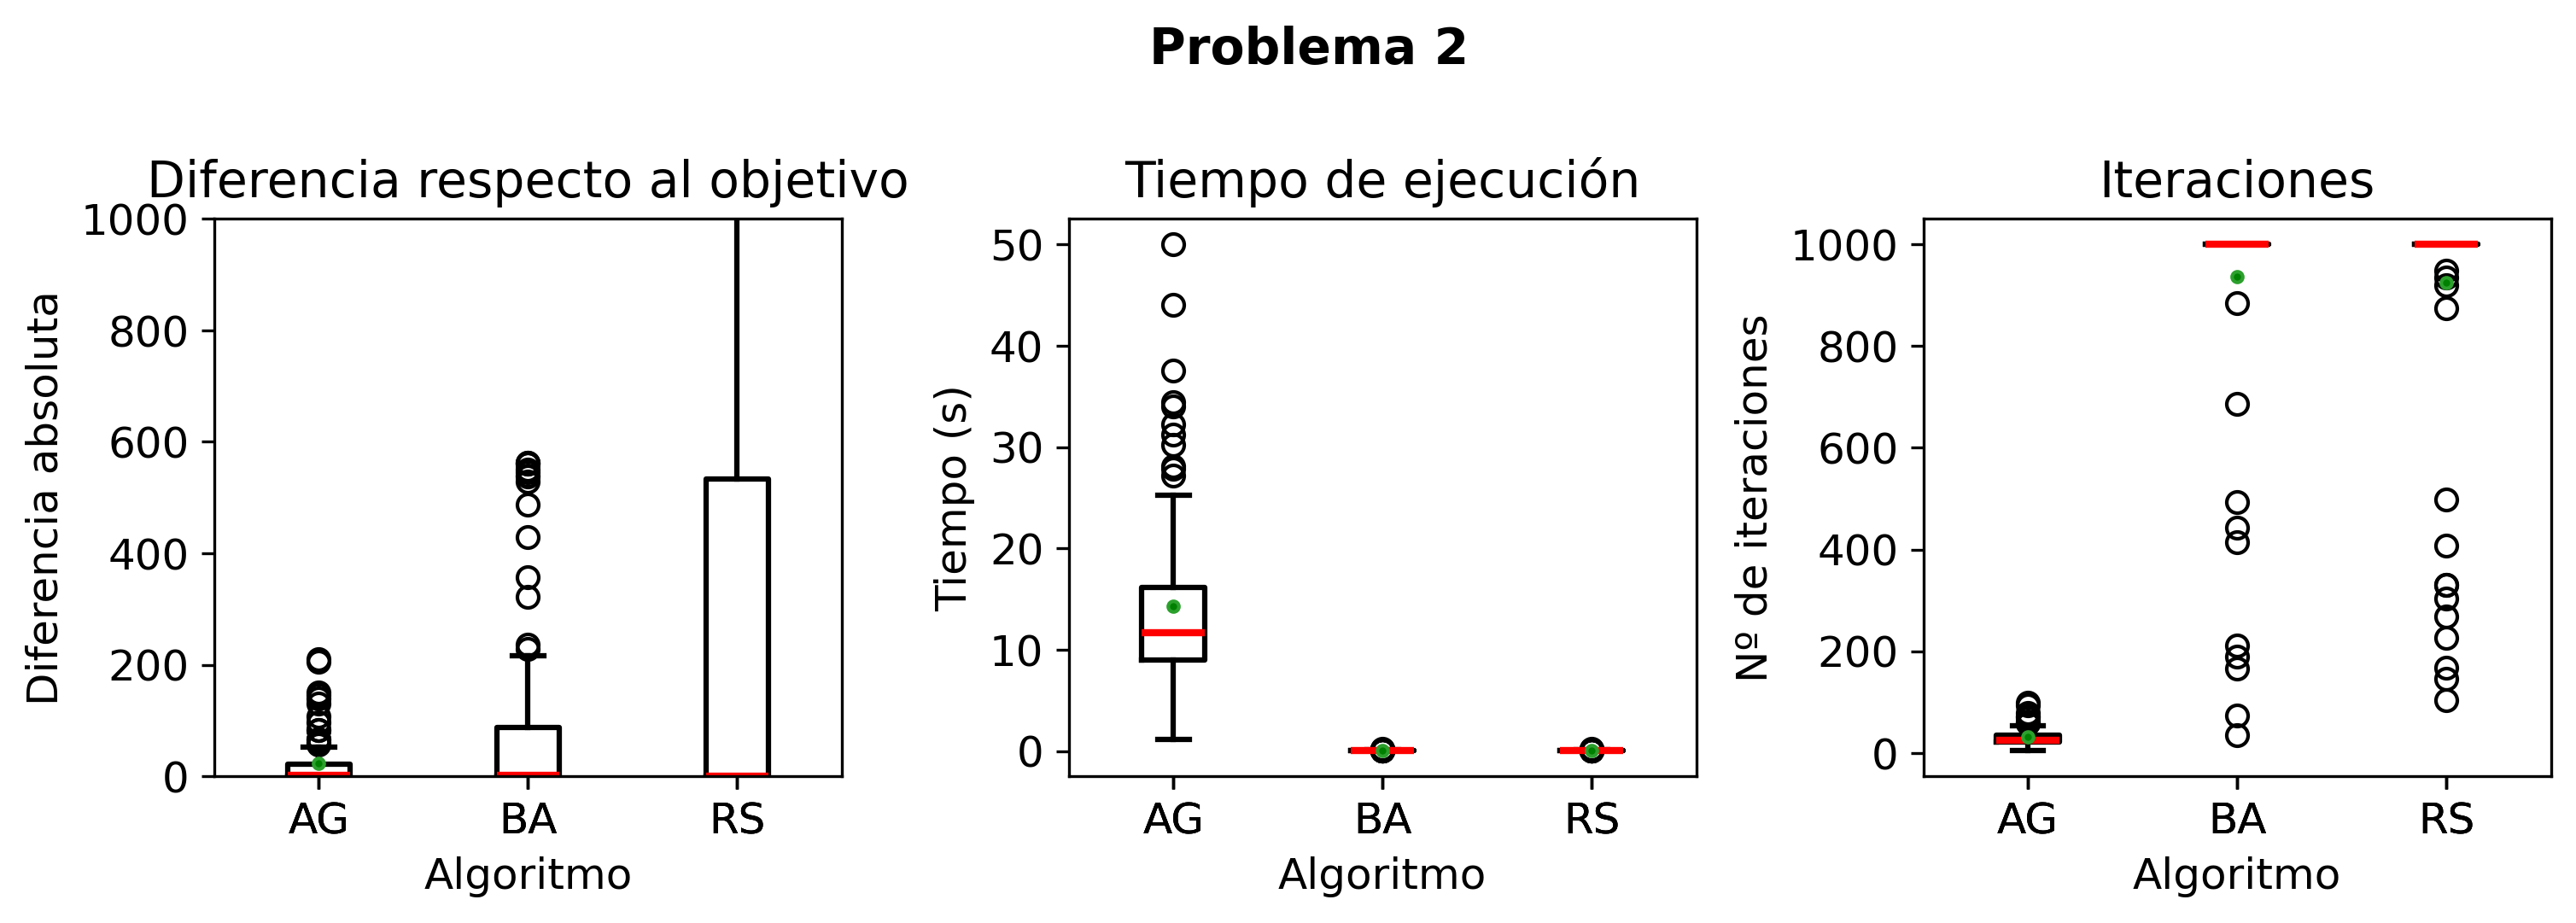

In [ ]:
fig, axes = plot_performance(P2df, "Problema 2")
axes['Mejor fitness'].set_ylim((0, 1000))
fig.show()

Number of times each algorithm reached the global optimum (tol = 0.01):

In [ ]:
count_success = pd.concat([P2df.groupby('Algoritmo')['Mejor fitness'].agg(lambda x: np.sum(x < 0.01)),
           P2df.groupby('Algoritmo')['Mejor fitness'].agg(lambda x: np.sum(x < 0.01) / x.shape[0] * 100)], axis=1)
count_success.columns = ['Nº éxitos', '% éxitos']
count_success

,Nº éxitos,% éxitos
Algoritmo,,
AG,8,8.0
BA,10,10.0
RS,14,14.0


Best solutions found:

In [ ]:
best_solutions = P2df.loc[P2df.groupby("Algoritmo")["Mejor fitness"].idxmin(), ["Algoritmo", "Mejor solución", "Mejor fitness"]]
pd.set_option('display.max_colwidth', None)
best_solutions

,Algoritmo,Mejor solución,Mejor fitness
103,AG,"[20, 3, 30, 50, 10, 35, 40, 25, 15, 60, 2, 7] ['/', '*', '+', '+', '+', '+', '+', '/', '-', '/', '-'] [2, 0, 1, 3, 4, 9, 8, 6, 7, 10, 5]",0.0
211,BA,"[30, 15, 10, 5, 20, 3, 23, 25, 35, 60, 2] ['-', '/', '+', '+', '*', '-', '*', '-', '-', '-'] [4, 6, 2, 7, 5, 1, 8, 3, 0, 9]",0.0
15,RS,"[35, 20, 5, 12, 2, 3, 60, 25, 7, 10] ['*', '-', '*', '-', '+', '-', '-', '+', '+'] [0, 2, 1, 4, 3, 5, 6, 7, 8]",0.0


# Problem P3

Results for problem P3 (`f`, `check_valid2`, `get_neighbour_nrpt`, `crossover_nrpt`):

In [ ]:
if RUN:
    P3df = run_algorithms(f, check_valid2, get_neighbour_nrpt, crossover_nrpt, N = N_RUNS, T0 = 500)
    save_csv(P3df, 'P3results.csv')
else:
    P3df = load_csv('P3results.csv')
    print("Loaded results. Number of runs: ", P3df[P3df['Algoritmo'] == 'RS'].shape[0])

Loaded results. Number of runs:  100


### Plot trajectories

Next, we plot the trajectories of each algorithm with envelopes indicating the standard error:

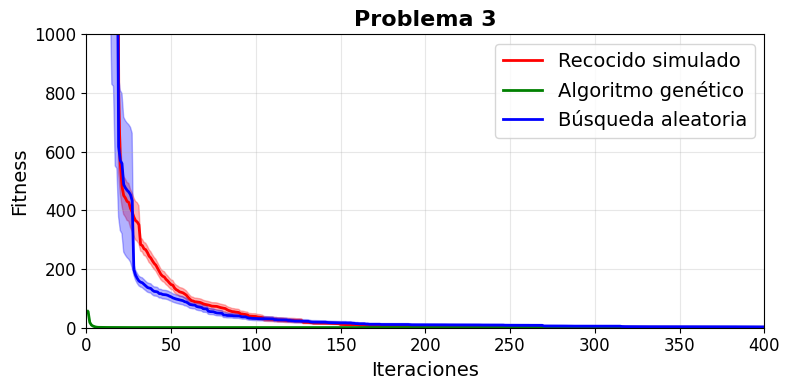

In [ ]:
plot_trajectories(P3df, "Problema 3", xlim=(0, 400), ylim=(0, 1000))

### Plot performance

Finally, we make a boxplot with the final solutions of each algorithm run:

<ipython-input-13-9a44b3d176eb>:107: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axes = df.boxplot(columns, by='Algoritmo', ax=fig, layout=(2, 3), sharey=False, return_type='axes', showmeans=True, fontsize=label_size, grid=False,


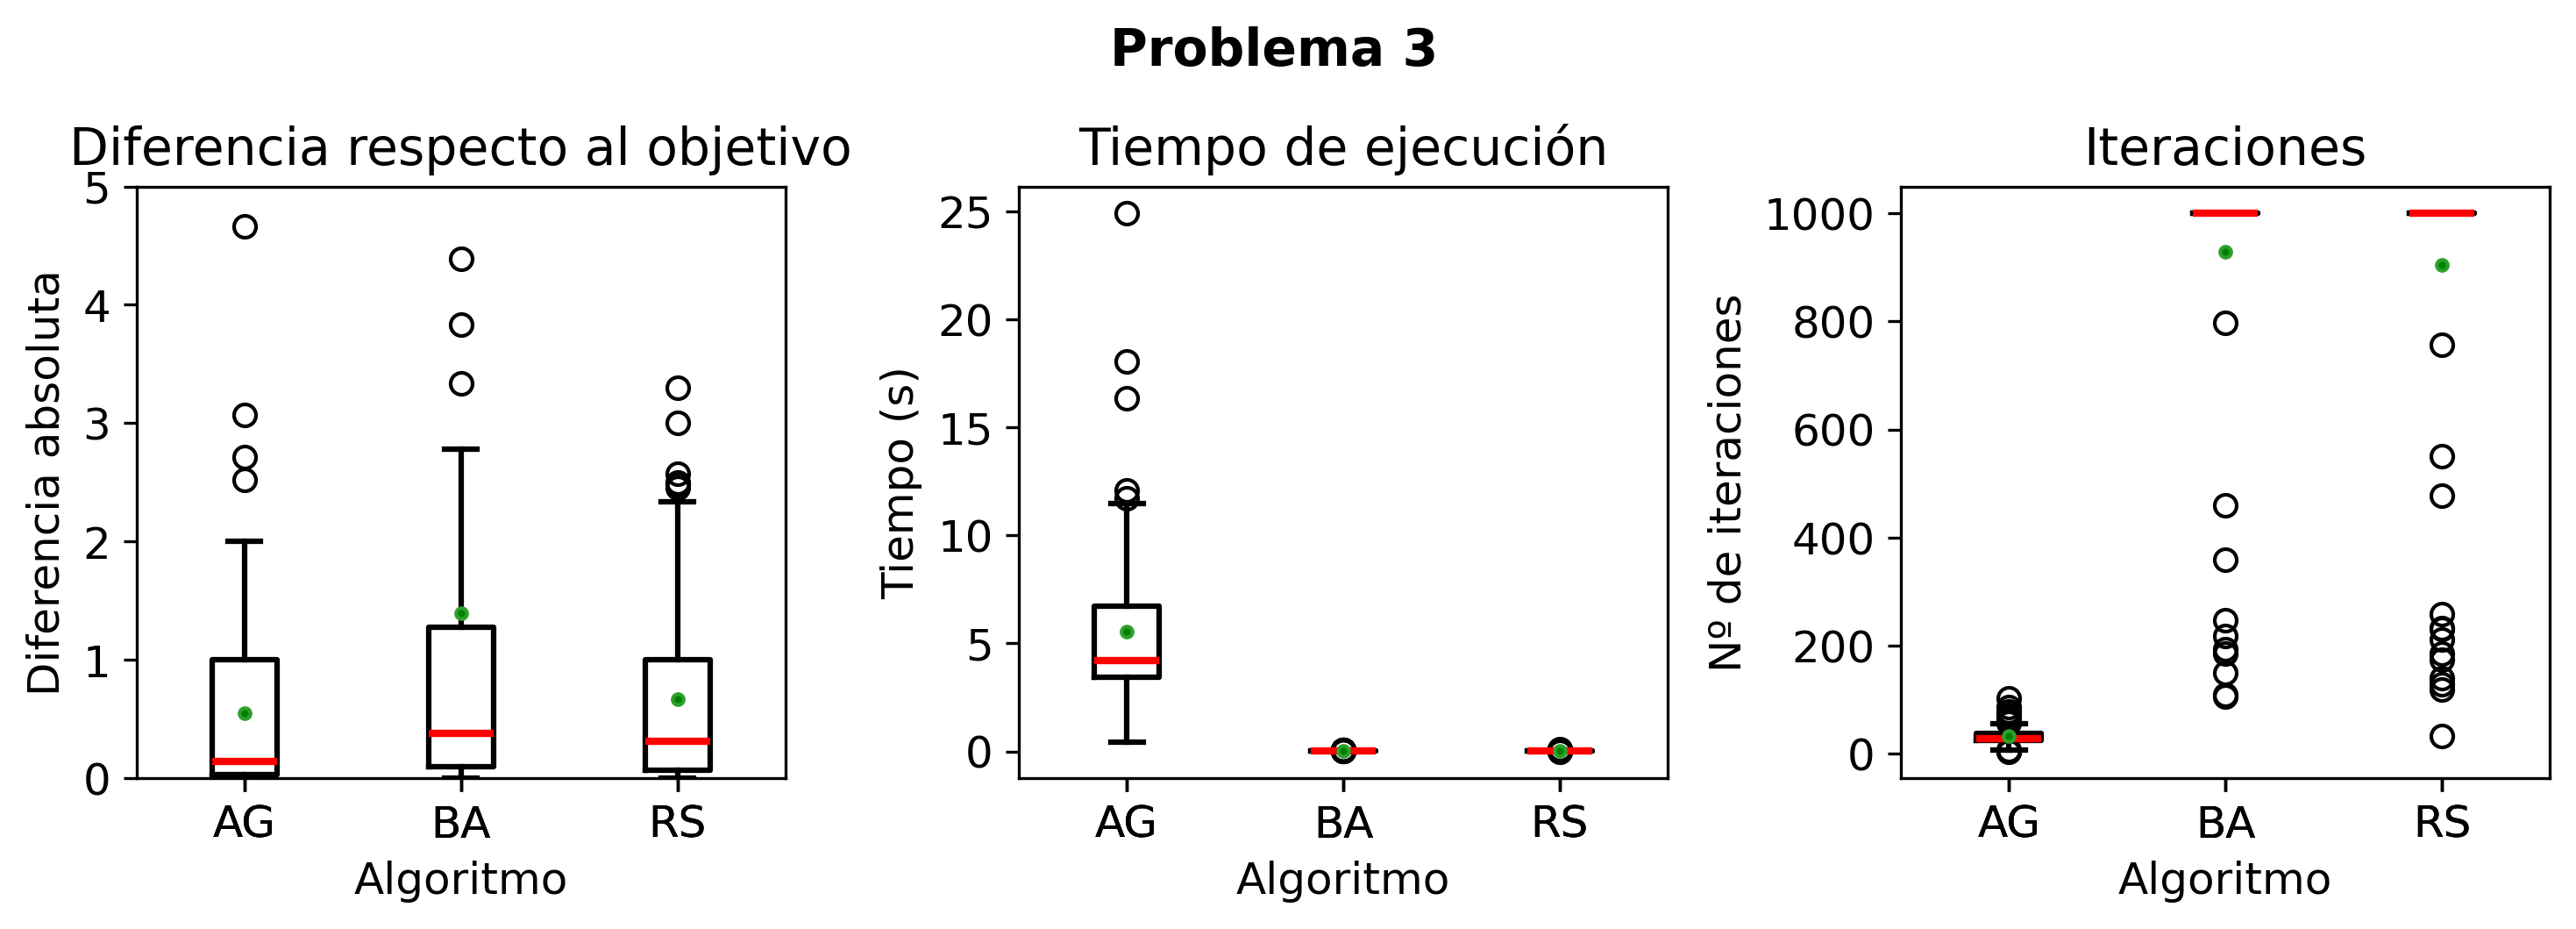

In [ ]:
fig, axes = plot_performance(P3df, "Problema 3")
axes['Mejor fitness'].set_ylim((0, 5))
plt.show()

Number of times each algorithm reached the global optimum (tol = 0.01):

In [ ]:
count_success = pd.concat([P3df.groupby('Algoritmo')['Mejor fitness'].agg(lambda x: np.sum(x < 0.01)),
           P3df.groupby('Algoritmo')['Mejor fitness'].agg(lambda x: np.sum(x < 0.01) / x.shape[0] * 100)], axis=1)
count_success.columns = ['Nº éxitos', '% éxitos']
count_success

,Nº éxitos,% éxitos
Algoritmo,,
AG,19,19.0
BA,10,10.0
RS,13,13.0


Best solutions found:

In [ ]:
best_solutions = P3df.loc[P3df.groupby("Algoritmo")["Mejor fitness"].idxmin(), ["Algoritmo", "Mejor solución", "Mejor fitness"]]
pd.set_option('display.max_colwidth', None)
best_solutions

,Algoritmo,Mejor solución,Mejor fitness
123,AG,"[30, 15, 23, 12, 50, 3, 7, 25, 20, 5, 2, 10] ['*', '+', '-', '+', '+', '+', '+', '+', '+', '*', '/'] [0, 2, 3, 1, 4, 10, 9, 8, 7, 6, 5]",0.0
205,BA,"[50, 12, 20, 5, 35, 10, 30, 60, 7, 23, 2, 3] ['+', '/', '/', '/', '/', '+', '-', '*', '-', '-', '-'] [3, 4, 1, 2, 6, 8, 7, 5, 0, 9, 10]",0.0
5,RS,"[40, 10, 5, 3, 20, 35, 23, 15] ['+', '/', '-', '+', '-', '*', '+'] [1, 2, 0, 3, 4, 5, 6]",0.0
